## Return Calculation and Evaluation Notebook

1. Data files that are input to this are local, so this cannot be run unless you have copies of those and edit the paths accordingly.
2. Based on Joel Greenblatt's 'Magic Formula'

In [1]:
import pandas as pd
import numpy as np 
import math

In [2]:
def pull_stocks(year:int, full_df, filter=None):

    df = full_df[((full_df['Year'].dt.year == year) & (full_df['Year'].dt.month == 3))]
    df = df.drop_duplicates('Stock')
    #df = df[df['P/E'] >= 5]
    if filter != None:
        df = df.sort_values('MCAP',ascending=False)
        df = df.head(filter)
    df = df[df.ROA >= 0.25]
    df = df.sort_values('P/E',ascending=True)

    return df['Stock']

def pull_stocks_score(year:int, full_df, filter=None):

    #Removing P/Es < 5 makes this return only financial stocks

    df = full_df[((full_df['Year'].dt.year == year) & (full_df['Year'].dt.month == 3))]
    df = df.drop_duplicates('Stock')
    #df = df[df['P/E'] >= 5]
    if filter != None:
        df = df.sort_values('MCAP',ascending=False)
        df = df.head(filter)
    df = df.sort_values('P/E',ascending=True)
    df['P/E_Rank'] = df['P/E'].rank(method='dense')

    df = df.sort_values('ROA',ascending=False)
    df['ROA_Rank'] = df['ROA'].rank(method='dense')

    df['Score'] = df['ROA_Rank'] + df['P/E_Rank']
    df = df.sort_values('Score',ascending=True)

    return df['Stock']

def pull_stocks_roce(year:int, full_df, filter=None):

    #Removing P/Es < 5 makes this return only financial stocks

    df = full_df[((full_df['Year'].dt.year == year) & (full_df['Year'].dt.month == 3))]
    df = df.drop_duplicates('Stock')
    #df = df[df['P/E'] >= 5]
    if filter != None:
        df = df.sort_values('MCAP',ascending=False)
        df = df.head(filter)
    df = df.sort_values('P/E',ascending=True)
    df['P/E_Rank'] = df['P/E'].rank(method='dense')

    df = df.sort_values('ROCE',ascending=False)
    df['ROCE_Rank'] = df['ROCE'].rank(method='dense')

    df['Score'] = df['ROCE_Rank'] + df['P/E_Rank']
    df = df.sort_values('Score',ascending=True)

    return df['Stock']

def pull_random(year:int, full_df, filter=None):

    df = full_df[((full_df['Year'].dt.year == year) & (full_df['Year'].dt.month == 3))]
    df = df.drop_duplicates('Stock')
    #df = df[df['P/E'] >= 5]
    if filter != None:
        df = df.sort_values('MCAP',ascending=False)
        df = df.head(filter)

    df = df.sample(frac=1, random_state=6).reset_index()

    return df['Stock']

def calc_return(year:int, stock_list, df):
    assert year < 2022 #we don't have data beyond this

    next_year = year+1

    ret_list=[]

    for stock in stock_list:
        curr = df.loc[str(stock), str(year)+'-03-31 00:00:00']
        next_price = df.loc[str(stock), str(next_year)+'-03-31 00:00:00']
        if (math.isnan(curr)  or math.isnan(next_price)):
            continue
        ret_list.append((next_price-curr)/curr)
    
    

    return ret_list


#Not working atm, scrip name differences between the databases
def fin_util_stocks(nifty_500:pd.DataFrame):

    fin_util = nifty_500[nifty_500.Industry == 'Financial Services']
    fin_list = [stock.upper() for stock in list(fin_util['Company Name'])]
    return fin_list

def yearly_return_calc(ret_list):

    year_end_val = [1+ret for ret in ret_list]
    final_val = sum(year_end_val)

    ret_percent = (final_val - len(year_end_val)) / len(year_end_val)

    return ret_percent

In [3]:
def calculate_cagr(returns:list):
    n = len(returns)
    
    multiplier = 1
    start_value = 100
    for i in range(n):
        multiplier *= (1+ returns[i])


    end_value = start_value * multiplier
    
    cagr = (end_value / start_value)**(1/n) - 1
    return cagr

In [4]:
def open_files():
    output_df_inp = pd.read_excel('/Users/sam/Documents/Coding/ML4Econ/Back_test/output_all_2.xlsx', engine='openpyxl', dtype='str')
    
    price_df_inp = pd.read_excel('/Users/sam/Documents/Coding/ML4Econ/Back_test/stock_prices_yearwise.xlsx', engine='openpyxl')
    price_df_inp.set_index('Stock',inplace=True)
    fin_df_inp = fin_util_stocks(pd.read_csv('/Users/sam/Documents/Coding/ML4Econ/Back_test/ind_nifty500list.csv'))
    return (output_df_inp, price_df_inp, fin_df_inp)

In [5]:
input_tup = open_files()

In [6]:
#Evaluations
def evaluate_strategy(pull_strategy, start=0, top_x=5, verbose=True, filter=None, remove_fin=False, input_tup = input_tup):


    #df = pd.read_excel('/Users/sam/Documents/Coding/ML4Econ/Back_test/output_all_2.xlsx', engine='openpyxl', dtype='str')
    df = input_tup[0]
    df['Year'] = pd.to_datetime(df['Year'])
    def convert_to_numeric(col):
        return pd.to_numeric(col, errors='ignore')

    df = df.apply(convert_to_numeric)
    df['Year'] = pd.to_datetime(df['Year'])

#OPEN THE NEXT DF
    #price_df = pd.read_excel('/Users/sam/Documents/Coding/ML4Econ/Back_test/stock_prices_yearwise.xlsx', engine='openpyxl')
    price_df = input_tup[1]
    #price_df.set_index('Stock',inplace=True)

    yearly_returns = []
    #fin_stocks = fin_util_stocks(pd.read_csv('/Users/sam/Documents/Coding/ML4Econ/Back_test/ind_nifty500list.csv'))
    fin_stocks = input_tup[2]
    #fin_stocks = [stock.upper() for stock in fin_stocks]

    for i in range(2013,2022,1):
        l = pull_strategy(i, df, filter=filter)
        #print(l)
        if remove_fin:
            l = [i for i in l if i not in fin_stocks]
        l = l[start:top_x]
        if verbose:
            print(f'Year: {i}\nStocks: {list(l)}')
            print(f'Return: {np.mean(calc_return(i,l,price_df)) * 100} %')
        yearly_returns.append(np.mean(calc_return(i,l,price_df)))
        
    cagr = calculate_cagr(yearly_returns)

    if verbose:
        print('---------------------------------------------')
        print(f"10 Year CAGR: {cagr *100}")
    return (cagr *100)

In [7]:
#NIFTY50 10 year CAGR = 13%
#This is the final evaluation function
_ = evaluate_strategy(pull_strategy=pull_random,start=0,top_x=10,verbose=True, filter=None, remove_fin=None,input_tup=input_tup)

Year: 2013
Stocks: ['MAHINDRA & MAHINDRA LTD', 'VARDHMAN TEXTILES LTD', 'GODREJ CONSUMER PRODUCTS LTD', 'THERMAX LTD', 'FEDERAL BANK LTD', 'JM FINANCIAL LTD', 'TITAN COMPANY LTD', 'JUBILANT PHARMOVA LTD', 'INDIA CEMENTS LTD', 'NIIT LTD']
Return: 14.371251399788122 %
Year: 2014
Stocks: ['JYOTHY LABS LTD', 'NLC INDIA LTD', 'JK PAPER LTD', 'JK TYRE & INDUSTRIES LTD', 'MAHINDRA & MAHINDRA FINANCIAL SERVICES LTD', 'ERIS LIFESCIENCES LTD', 'JINDAL STAINLESS LTD', 'EPL LTD', 'PCBL LTD', 'MAHARASHTRA SEAMLESS LTD']
Return: 54.828901364299846 %
Year: 2015
Stocks: ['SRF LTD', 'GENERAL INSURANCE CORPORATION OF INDIA', 'TORRENT PHARMACEUTICALS LTD', 'INFOSYS LTD', 'CUMMINS INDIA LTD', 'INOX LEISURE LTD', 'J B CHEMICALS & PHARMACEUTICALS LTD', 'UNO MINDA LTD', 'V I P INDUSTRIES LTD', 'NEW INDIA ASSURANCE COMPANY LTD']
Return: 22.562738857236443 %
Year: 2016
Stocks: ['NAVIN FLUORINE INTERNATIONAL LTD', 'MASTEK LTD', 'GODREJ INDUSTRIES LTD', 'MAHINDRA & MAHINDRA LTD', 'EMAMI LTD', 'ADVANCED ENZYME TE

In [8]:
#Creating data to plot

y = []
x = []
k = 6
for i in range(0,304,k):
    #print(f'Index: {i, i+k}')
    y.append(evaluate_strategy(pull_strategy=pull_stocks_score,start=i,top_x=i+k,verbose=False, filter=None, remove_fin=True))
    #print('================================================')
    x.append(i)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
sns.set_palette('coolwarm')
sns.set_style("whitegrid", {'font.family':'serif', 'font.serif':'Times New Roman', 'font.size':12, 'lines.linewidth':2})

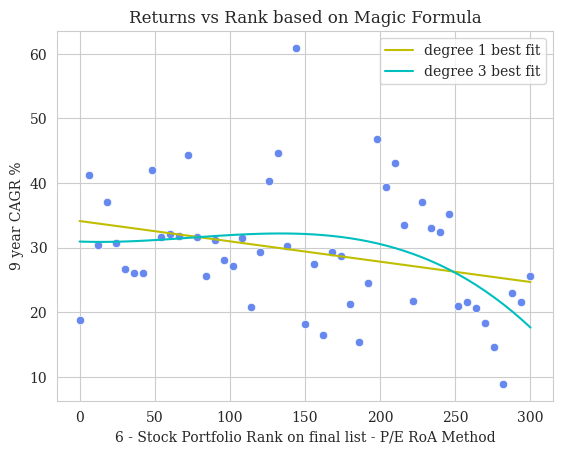

In [11]:
coefficients = np.polyfit(x, y, 1)
p = np.poly1d(coefficients)
p2 = np.poly1d(np.polyfit(x, y, 3))
sns.scatterplot(x=x, y=y)
plt.ylabel('9 year CAGR %')
plt.xlabel(f'{k} - Stock Portfolio Rank on final list - P/E RoA Method')
plt.title('Returns vs Rank based on Magic Formula')
plt.plot(x, p(x), color='y', label ='degree 1 best fit')
plt.plot(x, p2(x), color='c', label = 'degree 3 best fit')
#plt.axhline(y=13, linestyle='--', color='r', label = 'Nifty50')

plt.legend()

In [12]:
import statsmodels.api as sm

In [13]:
Y = y
X = np.array(x)
#X = np.column_stack((x))
X = sm.add_constant(X)
mod = sm.OLS(Y,X, missing='drop')
res = mod.fit(cov_type='HC3')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     5.773
Date:                Wed, 01 Mar 2023   Prob (F-statistic):             0.0201
Time:                        17:11:31   Log-Likelihood:                -185.17
No. Observations:                  51   AIC:                             374.3
Df Residuals:                      49   BIC:                             378.2
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.1248      2.241     15.228      0.000      29.733      38.517
x1            -0.0315      0.013     -2.403      0.016      -0.057      -0.006
==============================================================================
Omnibus:                       10.299   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.145
Skew:                           0.888   Prob(JB):                      0.00627
Kurtosis:                       4.274   Cond. No.                         343.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [14]:
y = []
x = []
k = 6
for i in range(0,304,k):
    #print(f'Index: {i, i+k}')
    y.append(evaluate_strategy(pull_strategy=pull_stocks_roce,start=i,top_x=i+k,verbose=False, filter=None, remove_fin=True))
    #print('================================================')
    x.append(i)

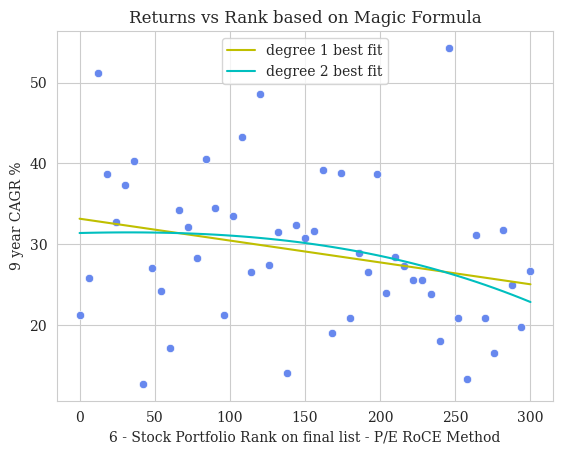

In [15]:
coefficients = np.polyfit(x, y, 1)
p = np.poly1d(coefficients)
p2 = np.poly1d(np.polyfit(x, y, 3))
sns.scatterplot(x=x, y=y)
plt.ylabel('9 year CAGR %')
plt.xlabel(f'{k} - Stock Portfolio Rank on final list - P/E RoCE Method')
plt.title('Returns vs Rank based on Magic Formula')
plt.plot(x, p(x), color='y', label ='degree 1 best fit')
plt.plot(x, p2(x), color='c', label = 'degree 2 best fit')
#plt.axhline(y=13, linestyle='--', color='r', label = 'Nifty50')

plt.legend()

In [16]:
Y = y
X = np.array(x)
#X = np.column_stack((x))
X = sm.add_constant(X)
mod = sm.OLS(Y,X, missing='drop')
res = mod.fit(cov_type='HC3')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.986
Date:                Wed, 01 Mar 2023   Prob (F-statistic):             0.0903
Time:                        17:11:35   Log-Likelihood:                -184.24
No. Observations:                  51   AIC:                             372.5
Df Residuals:                      49   BIC:                             376.3
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.1436      2.843     11.657      0.000      27.571      38.716
x1            -0.0271      0.016     -1.728      0.084      -0.058       0.004
==============================================================================
Omnibus:                        4.806   Durbin-Watson:                   2.360
Prob(Omnibus):                  0.090   Jarque-Bera (JB):                3.704
Skew:                           0.534   Prob(JB):                        0.157
Kurtosis:                       3.776   Cond. No.                         343.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [17]:
y = []
x = []
k = 6
for i in range(0,304,k):
    #print(f'Index: {i, i+k}')
    try:
        y.append(evaluate_strategy(pull_strategy=pull_random,start=i,top_x=i+k,verbose=False, filter=None, remove_fin=False))
    except: continue
    #print('================================================')
    x.append(i)

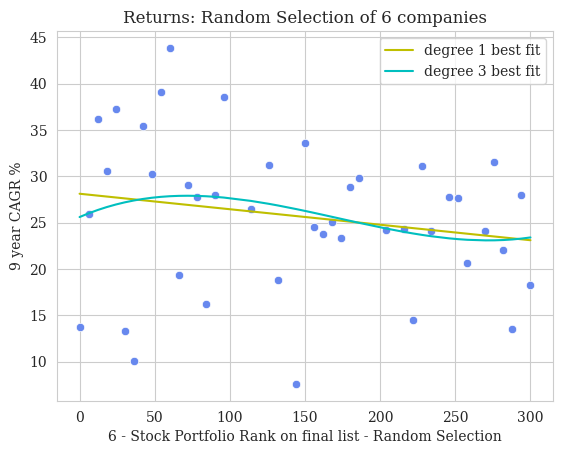

In [18]:
coefficients = np.polyfit(x, y, 1)
p = np.poly1d(coefficients)
p2 = np.poly1d(np.polyfit(x, y, 3))
sns.scatterplot(x=x, y=y)
plt.ylabel('9 year CAGR %')
plt.xlabel(f'{k} - Stock Portfolio Rank on final list - Random Selection')
plt.title(f'Returns: Random Selection of {k} companies')
plt.plot(x, p(x), color='y', label ='degree 1 best fit')
plt.plot(x, p2(x), color='c', label = 'degree 3 best fit')
#plt.axhline(y=13, linestyle='--', color='r', label = 'Nifty50')

plt.legend()

In [19]:
Y = y
X = np.array(x)
#X = np.column_stack((x))
X = sm.add_constant(X)
mod = sm.OLS(Y,X, missing='drop')
res = mod.fit(cov_type='HC3')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.344
Date:                Wed, 01 Mar 2023   Prob (F-statistic):              0.253
Time:                        17:11:38   Log-Likelihood:                -146.28
No. Observations:                  42   AIC:                             296.6
Df Residuals:                      40   BIC:                             300.0
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.1219      2.943      9.556      0.000      22.354      33.890
x1            -0.0167      0.014     -1.159      0.246      -0.045       0.012
==============================================================================
Omnibus:                        1.787   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.404
Skew:                          -0.446   Prob(JB):                        0.495
Kurtosis:                       2.919   Cond. No.                         318.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [20]:
#This is strange. How can a random sample of stocks every year generate returns like this?
np.mean([elem for elem in y if not math.isnan(elem)])

25.70066739968547

In [21]:
(14664 / 4660)**(1/9) - 1

0.13584351790630333

In [39]:
y = []
for i in range(1000):
    def pull_random(year:int, full_df, filter=None):

        df = full_df[((full_df['Year'].dt.year == year) & (full_df['Year'].dt.month == 3))]
        df = df.drop_duplicates('Stock')
        #df = df[df['P/E'] >= 5]
        if filter != None:
            df = df.sort_values('MCAP',ascending=False)
            df = df.head(filter)

        df = df.sample(frac=1, random_state=i).reset_index()

        return df['Stock']
    try:
        y.append(evaluate_strategy(pull_strategy=pull_random,start=0,top_x=10,verbose=False, filter=None, remove_fin=None,input_tup=input_tup))
    except: continue

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/an

In [40]:
np.mean(y), np.std(y)

(nan, nan)

Text(0.5, 1.0, 'Performance of Random Selection')

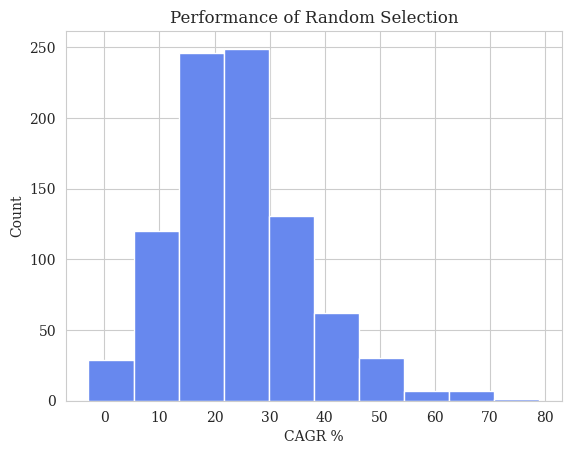

In [42]:
plt.hist(x=y)
plt.ylabel('Count')
plt.xlabel('CAGR %')
plt.title('Performance of Random Selection')
#This makes very little sense to me. How can the mean be so high.

In [45]:
np.mean([elem for elem in y if not math.isnan(elem)])

24.368588198917813